In [28]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline as imbl_pipe
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import tree
import xgboost as xgb
import joblib
from tensorflow.keras.models import load_model

In [29]:
df = pd.read_csv(os.path.join("Resources", "analytical_base_table.csv"))
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
#Sperate target and others
y = df.Exited
X = df.drop(['Exited'], axis=1)
print(X.shape, y.shape)

(10000, 10) (10000,)


In [31]:
random_state = 10
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                   stratify=df.Exited)
#X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [32]:
#Numpy representation
X_train = X_train.values
X_test = X_test.values

In [33]:
dt_model = joblib.load('models/nate_decision_tree.sav')
lr_model = joblib.load('models/nate_logistic_regression.sav')
rf_model = joblib.load('models/nate_random_forest.sav')
svm_model = joblib.load('models/SVM_model.sav')
xgb_model = joblib.load('models/XGBoost_model.sav')

In [34]:
#Model dict for ease of plotting 
models = {
    'dt' : 'Decision Tree',
    'lr' : 'Logistic Regression',
    'rf' : 'Random Forest',
    'svm' : 'Support Vector Machine (SVM)',
    'xgb' : 'XGBoost'
}

In [35]:
loaded_models = {
    'dt' : dt_model,
    'lr' : lr_model,
    'rf' : rf_model,
    'svm' : svm_model,
    'xgb' : xgb_model
}

In [36]:
target_names = ['Stays', 'Exits']

In [37]:
def evaluation(fit_models):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)
        lst.append([name, 
                    precision_score(y_test, pred, average='macro'),
                    recall_score(y_test, pred, average='macro'),
                    f1_score(y_test, pred, average='macro'),
                    accuracy_score(y_test, pred)])
    eval_df = pd.DataFrame(lst, columns=['model', 'precision', 'recall', 'f1_macro', 'accuracy'])
    eval_df.set_index('model', inplace = True)
    return eval_df

In [38]:
def class_rep_cm(fit_models, models, model_id):
    # Prediction using model id 
    pred = fit_models[model_id].predict(X_test)
    print()
    print('\t', models[model_id])
    print('\t', '='*len(models[model_id]))
    conf_df = pd.DataFrame(confusion_matrix(y_test, pred), columns=target_names, index=target_names)
    conf_df.index.name = 'True Labels'
    conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
    display(conf_df)
    print()
    print(classification_report(y_test, pred, target_names=target_names))


In [39]:
def plot_conf_mat_w_and_wo_norm(fit_models, models, model_id, color):
    # Plot confusion matrix heatmaps
    pred = fit_models[model_id].predict(X_test)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.suptitle(models[model_id], fontsize=14)
    f.subplots_adjust(top=0.85, wspace=0.3)
    mat = confusion_matrix(y_test, pred) # CM without normalization
    sns.heatmap(mat,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='d',
                cbar=True,
                square=True,
                cmap=color,
                ax=ax1)
    ax1.set_xticklabels(labels=target_names)
    ax1.set_yticklabels(labels=target_names, va='center')
    ax1.set_title('Confusion Matrix w/o Normalization')
    ax1.set_xlabel('Predicted Label', size=12)
    ax1.set_ylabel('True Label', size=12)
    matn = mat / mat.sum(axis=1)[:, np.newaxis]# CM with Normalization
    sns.heatmap(matn,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='.2f',
                cbar=True,
                square=True,
                cmap=color,
                vmin = 0,
                vmax = 1,
                ax=ax2)
    ax2.set_xticklabels(labels=target_names)
    ax2.set_yticklabels(labels=target_names, va='center')
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_xlabel('Predicted Label', size=12)
    ax2.set_ylabel('True Label', size=12)
    plt.show()

In [40]:
# Creating plots and subplots 
def plot_norm_conf_matrices(fit_models, models, color):
    lt = []
    ltd = []
    col = 2
    n_mod = len(fit_models)
    row = - (n_mod // -col)
    for r in range(row):
        for c in range(col):
            if n_mod >= (r + 1) * (c + 1):
                lt.append([r, c])
            else:
                ltd.append([r, c])
    figs_y = row * 4  # y size
    f, axs = plt.subplots(row, col, figsize=(10, figs_y))
    f.suptitle('Normalized Confusion Matrices', fontsize=14)
    f.subplots_adjust(top=0.94, wspace=0.90, hspace=0.2)
    axs = axs.reshape(row,-col)
    for n in range(len(ltd)):
        r = ltd[n][0]
        c = ltd[n][1]
        f.delaxes(ax= axs[r, c])
    i = 0
    for id, model in fit_models.items():
        pred = model.predict(X_test)
        name = models[id]
        r = lt[i][0]
        c = lt[i][1]
        i += 1
        mat = confusion_matrix(y_test, pred)    
        matn = mat / mat.sum(axis=1)[:, np.newaxis]
        ax = axs[r, c]
        sns.heatmap(matn,
                    annot=True,
                    annot_kws=dict(fontsize=14),
                    fmt='.2f',
                    cbar=False,
                    square=True,
                    cmap=color,
                    vmin = 0,
                    vmax = 1,
                    ax=ax)
        ax.set_xticklabels(labels=target_names)
        ax.set_yticklabels(labels=target_names, va='center')
        ax.set_title(name)
        ax.set_xlabel('Predicted Label', size=12)
        ax.set_ylabel('True Label', size=12)
    plt.show()

In [41]:
# Display evaluation metrics
evaluation(loaded_models)

,precision,recall,f1_macro,accuracy
model,,,,
dt,0.705436,0.752161,0.721427,0.797333
lr,0.636816,0.695442,0.639900,0.707000
rf,0.747848,0.754113,0.750886,0.836333
svm,0.695332,0.763927,0.710934,0.775333
xgb,0.773797,0.760505,0.766781,0.852333


In [42]:
#Eval metric for all models 
for model in models.keys():
    class_rep_cm(loaded_models, models, model)


	 Decision Tree


Predicted Labels,Stays,Exits
True Labels,,
Stays,1979,410
Exits,198,413



              precision    recall  f1-score   support

       Stays       0.91      0.83      0.87      2389
       Exits       0.50      0.68      0.58       611

    accuracy                           0.80      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000


	 Logistic Regression


Predicted Labels,Stays,Exits
True Labels,,
Stays,1708,681
Exits,198,413



              precision    recall  f1-score   support

       Stays       0.90      0.71      0.80      2389
       Exits       0.38      0.68      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000


	 Random Forest


Predicted Labels,Stays,Exits
True Labels,,
Stays,2133,256
Exits,235,376



              precision    recall  f1-score   support

       Stays       0.90      0.89      0.90      2389
       Exits       0.59      0.62      0.60       611

    accuracy                           0.84      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000


	 Support Vector Machine (SVM)


Predicted Labels,Stays,Exits
True Labels,,
Stays,1871,518
Exits,156,455



              precision    recall  f1-score   support

       Stays       0.92      0.78      0.85      2389
       Exits       0.47      0.74      0.57       611

    accuracy                           0.78      3000
   macro avg       0.70      0.76      0.71      3000
weighted avg       0.83      0.78      0.79      3000


	 XGBoost


Predicted Labels,Stays,Exits
True Labels,,
Stays,2187,202
Exits,241,370



              precision    recall  f1-score   support

       Stays       0.90      0.92      0.91      2389
       Exits       0.65      0.61      0.63       611

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



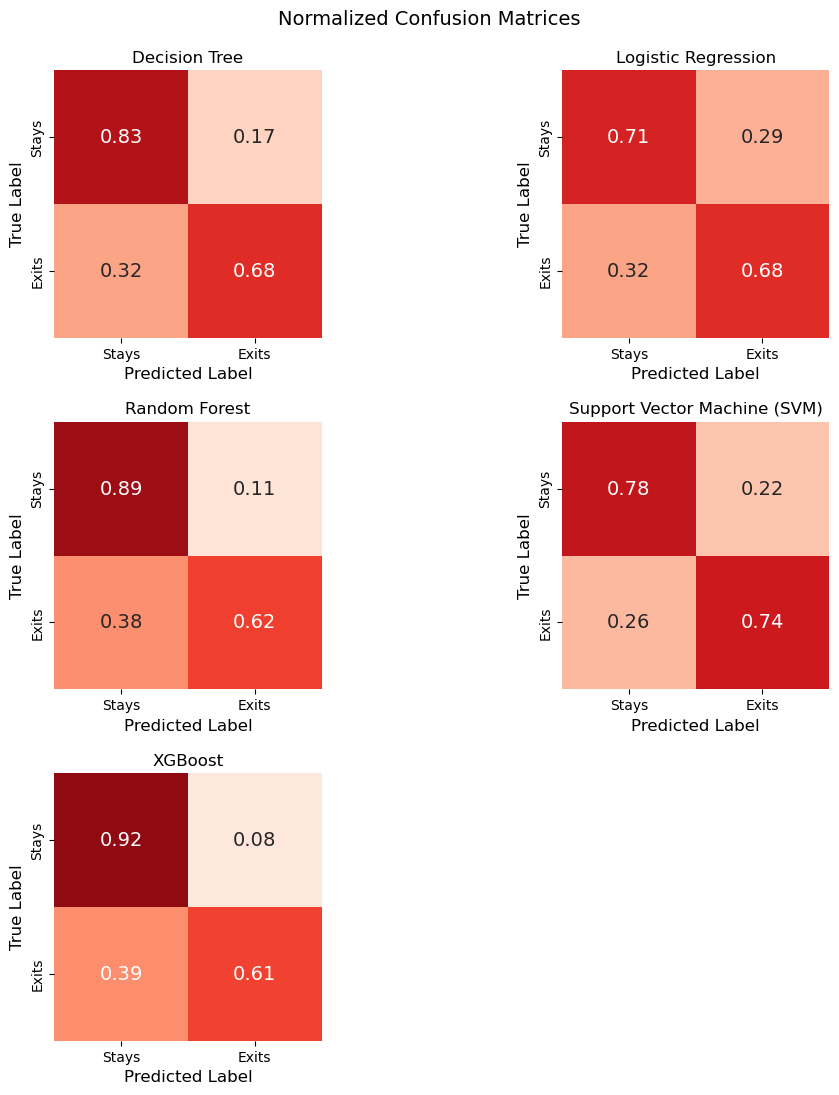

In [43]:
# VIZ for all Confusion matrices
plot_norm_conf_matrices(loaded_models, models, 'Reds')

In [44]:
# COmpare SVM with SMOTE and without 
svm_model_nos = joblib.load('models/SVM_model_nos.sav')
svm_model_s = joblib.load('models/SVM_model_s.sav')

In [45]:
models_svm = {
    'svm_nos' : 'SVM - without SMOTE',
    'svm_s' : 'SVM - with SMOTE'
}

In [46]:
loaded_models_svm = {
    'svm_nos' : svm_model_nos,
    'svm_s' : svm_model_s
}

In [47]:
for model in models_svm.keys():
    class_rep_cm(loaded_models_svm, models_svm, model)


	 SVM - without SMOTE


Predicted Labels,Stays,Exits
True Labels,,
Stays,2312,77
Exits,328,283



              precision    recall  f1-score   support

       Stays       0.88      0.97      0.92      2389
       Exits       0.79      0.46      0.58       611

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.86      0.85      3000


	 SVM - with SMOTE


Predicted Labels,Stays,Exits
True Labels,,
Stays,1871,518
Exits,156,455



              precision    recall  f1-score   support

       Stays       0.92      0.78      0.85      2389
       Exits       0.47      0.74      0.57       611

    accuracy                           0.78      3000
   macro avg       0.70      0.76      0.71      3000
weighted avg       0.83      0.78      0.79      3000



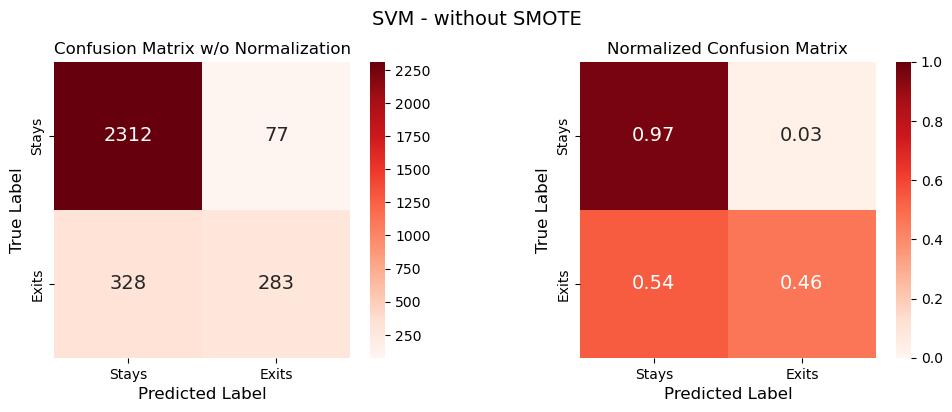

In [48]:
#Normalize confusion matrix
plot_conf_mat_w_and_wo_norm(loaded_models_svm, models_svm, 'svm_nos', 'Reds')

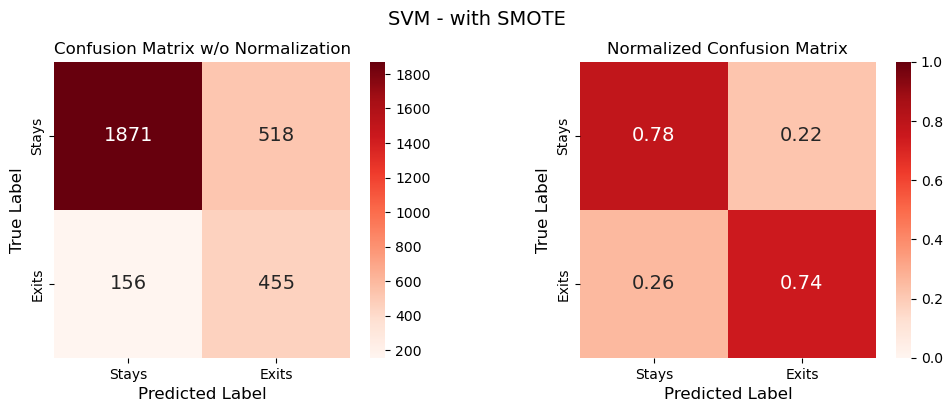

In [49]:
plot_conf_mat_w_and_wo_norm(loaded_models_svm, models_svm, 'svm_s', 'Reds')

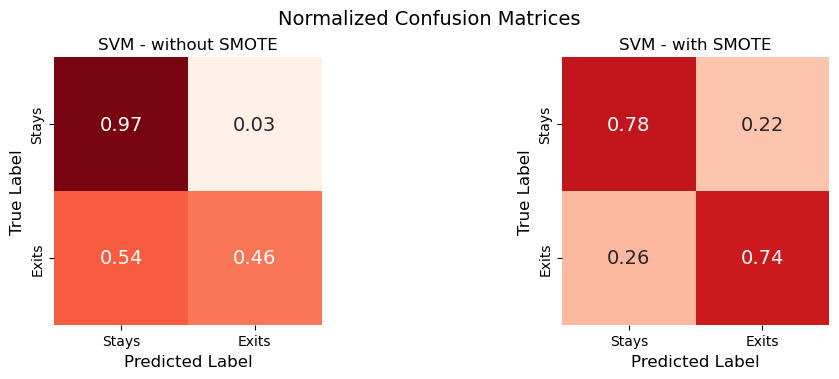

In [50]:
# Plot both 
plot_norm_conf_matrices(loaded_models_svm, models_svm, 'Reds')